# Exploring Trends in Most Populous Cities of the United States

### Introduction

Company X wishes to branch out their business chain by opening new locations in ideal US cities. To identify which US cities might be ideal candidates we explore relationships between the most populous US cities and the types of venues that correspond to each. We will then perform agglomerative hierarchical clustering to see which of the top 200 most populous US cities might be worthy of looking into further. The hierarchical clustering will be based on population, population change (percent increase/decrease), and most common types of venues that exist within them. Once the hierarchical clustering is completed, a more in-depth study can then be performed by Company X. Therefore, this work is a preliminary investigation step.

##### Data Collection

To start with, we scrape Wikipedia's page for the list of most populous US cities with their corresponding percent-increase/percent-decrease:

https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

Then, using this initial data set with the corresponding GPS locations (included in the data table), we will obtain venues using the Foursquare API and investigate the trending venues.

I perform the scrape below.

##### Importing Libraries:

In [1]:
# import necessary libraries

# import numpy
import numpy as np

# import pandas
import pandas as pd

# import web scraping tools
from urllib.request import urlopen
from bs4 import BeautifulSoup

# library to handle JSON files
import json

# import geocoder
import geocoder

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# import folium for maps
import folium

# library to handle requests
import requests

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [2]:
def get_html_contents(page_url):
    results = requests.get(page_url) # access url location
    soup = BeautifulSoup(results.text,'html.parser') # parse through html of url and store page info
    return soup
    
cities_url = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population' # define desired url

cities_contents = get_html_contents(cities_url)

In [3]:
city_pop_table = cities_contents.find('table',{'class': 'wikitable sortable'}) # find the first table of class 'wikitable sortable'
city_pop_header = city_pop_table.tr.find_all('th') # create html table headers list

column_names = [] # create empty list

for header in city_pop_header:
    column_names.append(header.text.strip().replace(',','_')) # collects column names as list
print(column_names)

['2020rank', 'City', 'State[c]', '2020estimate', '2010census', 'Change', '2016 land area', '2016 population density', 'Location']


In [4]:
file_name = 'us_cities_data_2020.csv' # give name to file

f = open(file_name,'w+', encoding='utf-8') # utf-8 encoding is used in html;
# will need to clean up

for i in range(len(column_names)): # write to file all column names as header to file
    if column_names[i] != column_names[-1]:
        f.write(column_names[i] + ',')
    else:
        f.write(column_names[i] + '\n')

table_rows = city_pop_table.find_all('tr') # list of all tr

for row in table_rows: # grab data from each cell and write to file
    cells = row.find_all('td')
    if len(cells) > 1:
        for i, cell in enumerate(cells):
            cell_data = cell.text.strip().replace(',','')
            if cells[i] != cells[-1]:
                if i == 7 or i == 9: # ignore metric units
                # assuming this is an American company so English units are desired
                    continue
                f.write(cell_data + ',')
            else:
                f.write(cell_data + '\n')
                    
f.close() # be sure to close the file!!!

In [5]:
us_cities_df = pd.read_csv('us_cities_data_2020.csv') # read csv file to obtain dataframe
us_cities_df.head() # take a peak at dataframe

,2020rank,City,State[c],2020estimate,2010census,Change,2016 land area,2016 population density,Location
0,1,New York[d],New York,8253213,8175133,+0.96%,301.5 sq mi,28317/sq mi,.mw-parser-output .geo-default.mw-parser-outpu...
1,2,Los Angeles,California,3970219,3792621,+4.68%,468.7 sq mi,8484/sq mi,34°01′N 118°25′W﻿ / ﻿34.01°N 118.41°W﻿ / 34.01...
2,3,Chicago,Illinois,2677643,2695598,−0.67%,227.3 sq mi,11900/sq mi,41°50′N 87°41′W﻿ / ﻿41.83°N 87.68°W﻿ / 41.83; ...
3,4,Houston,Texas,2316120,2100263,+10.28%,637.5 sq mi,3613/sq mi,29°47′N 95°23′W﻿ / ﻿29.78°N 95.39°W﻿ / 29.78; ...
4,5,Phoenix,Arizona,1708127,1445632,+18.16%,517.6 sq mi,3120/sq mi,33°34′N 112°05′W﻿ / ﻿33.57°N 112.09°W﻿ / 33.57...


##### Data Cleaning:

In [6]:
cities_cleaned = [] # initialize an empty list

for i, text in enumerate(us_cities_df.index): # cleans city names and appends to list
    cities_cleaned.append(us_cities_df.loc[i,'City'].split('[')[0])
    
print(cities_cleaned) # take a peak

['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose', 'Austin', 'Fort Worth', 'Jacksonville', 'Columbus', 'Charlotte', 'Indianapolis', 'San Francisco', 'Seattle', 'Denver', 'Washington', 'Boston', 'El Paso', 'Nashville', 'Detroit', 'Las Vegas', 'Oklahoma City', 'Portland', 'Memphis', 'Louisville', 'Milwaukee', 'Baltimore', 'Albuquerque', 'Tucson', 'Fresno', 'Mesa', 'Sacramento', 'Atlanta', 'Kansas City', 'Colorado Springs', 'Omaha', 'Raleigh', 'Miami', 'Long Beach', 'Virginia Beach', 'Minneapolis', 'Oakland', 'Tampa', 'Tulsa', 'Arlington', 'Wichita', 'New Orleans', 'Aurora', 'Bakersfield', 'Cleveland', 'Anaheim', 'Honolulu', 'Santa Ana', 'Riverside', 'Henderson', 'Corpus Christi', 'Lexington', 'Stockton', 'Saint Paul', 'Cincinnati', 'Pittsburgh', 'Greensboro', 'St. Louis', 'Plano', 'Lincoln', 'Orlando', 'Anchorage', 'Durham', 'Irvine', 'Newark', 'Chula Vista', 'Fort Wayne', 'Toledo', 'St. Petersburg', 'Chandler', 

In [7]:
us_cities_df['City'] = pd.Series(cities_cleaned) # repleace 'City' column with newly cleaned names
us_cities_df.head()

,2020rank,City,State[c],2020estimate,2010census,Change,2016 land area,2016 population density,Location
0,1,New York,New York,8253213,8175133,+0.96%,301.5 sq mi,28317/sq mi,.mw-parser-output .geo-default.mw-parser-outpu...
1,2,Los Angeles,California,3970219,3792621,+4.68%,468.7 sq mi,8484/sq mi,34°01′N 118°25′W﻿ / ﻿34.01°N 118.41°W﻿ / 34.01...
2,3,Chicago,Illinois,2677643,2695598,−0.67%,227.3 sq mi,11900/sq mi,41°50′N 87°41′W﻿ / ﻿41.83°N 87.68°W﻿ / 41.83; ...
3,4,Houston,Texas,2316120,2100263,+10.28%,637.5 sq mi,3613/sq mi,29°47′N 95°23′W﻿ / ﻿29.78°N 95.39°W﻿ / 29.78; ...
4,5,Phoenix,Arizona,1708127,1445632,+18.16%,517.6 sq mi,3120/sq mi,33°34′N 112°05′W﻿ / ﻿33.57°N 112.09°W﻿ / 33.57...


In [8]:
location_cleaned = [] # initialize empty list

for i, content in enumerate(us_cities_df.index): # cleaning location lat/long coords
    location_cleaned.append(us_cities_df.loc[i,'Location'].replace('\ufeff','').split('/')[2].split('(')[0].replace(' ',''))
    
lat_coords = [] # initialize
long_coords = [] # initialize

for i, text in enumerate(location_cleaned): # separate lat and long coords into separate lists
    lat, long = location_cleaned[i].split(';')
    lat_coords.append(lat)
    long_coords.append(long)

us_cities_df['Lat'] = pd.Series(lat_coords).astype(float) # add column for latidude
us_cities_df['Long'] = pd.Series(long_coords).astype(float) # add column for longitude
us_cities_df.head() # take a peak

,2020rank,City,State[c],2020estimate,2010census,Change,2016 land area,2016 population density,Location,Lat,Long
0,1,New York,New York,8253213,8175133,+0.96%,301.5 sq mi,28317/sq mi,.mw-parser-output .geo-default.mw-parser-outpu...,40.66,-73.93
1,2,Los Angeles,California,3970219,3792621,+4.68%,468.7 sq mi,8484/sq mi,34°01′N 118°25′W﻿ / ﻿34.01°N 118.41°W﻿ / 34.01...,34.01,-118.41
2,3,Chicago,Illinois,2677643,2695598,−0.67%,227.3 sq mi,11900/sq mi,41°50′N 87°41′W﻿ / ﻿41.83°N 87.68°W﻿ / 41.83; ...,41.83,-87.68
3,4,Houston,Texas,2316120,2100263,+10.28%,637.5 sq mi,3613/sq mi,29°47′N 95°23′W﻿ / ﻿29.78°N 95.39°W﻿ / 29.78; ...,29.78,-95.39
4,5,Phoenix,Arizona,1708127,1445632,+18.16%,517.6 sq mi,3120/sq mi,33°34′N 112°05′W﻿ / ﻿33.57°N 112.09°W﻿ / 33.57...,33.57,-112.09


In [9]:
us_cities_df.drop('Location',axis=1,inplace=True) # drop messy location column
us_cities_df.head()

,2020rank,City,State[c],2020estimate,2010census,Change,2016 land area,2016 population density,Lat,Long
0,1,New York,New York,8253213,8175133,+0.96%,301.5 sq mi,28317/sq mi,40.66,-73.93
1,2,Los Angeles,California,3970219,3792621,+4.68%,468.7 sq mi,8484/sq mi,34.01,-118.41
2,3,Chicago,Illinois,2677643,2695598,−0.67%,227.3 sq mi,11900/sq mi,41.83,-87.68
3,4,Houston,Texas,2316120,2100263,+10.28%,637.5 sq mi,3613/sq mi,29.78,-95.39
4,5,Phoenix,Arizona,1708127,1445632,+18.16%,517.6 sq mi,3120/sq mi,33.57,-112.09


In [10]:
us_cities_df.rename(columns={'2020rank': '2020 Rank',
                             'State[c]': 'State',
                             '2020estimate': '2018 Estimate',
                             '2010census': '2010 Census',
                             '2016 land area': 'Land Area (sq mi)',
                             '2016 population density': 'Population Density (per sq mi)'},
                    inplace=True) # renaming columns for cleaner look and easier use
us_cities_df.head()

,2020 Rank,City,State,2018 Estimate,2010 Census,Change,Land Area (sq mi),Population Density (per sq mi),Lat,Long
0,1,New York,New York,8253213,8175133,+0.96%,301.5 sq mi,28317/sq mi,40.66,-73.93
1,2,Los Angeles,California,3970219,3792621,+4.68%,468.7 sq mi,8484/sq mi,34.01,-118.41
2,3,Chicago,Illinois,2677643,2695598,−0.67%,227.3 sq mi,11900/sq mi,41.83,-87.68
3,4,Houston,Texas,2316120,2100263,+10.28%,637.5 sq mi,3613/sq mi,29.78,-95.39
4,5,Phoenix,Arizona,1708127,1445632,+18.16%,517.6 sq mi,3120/sq mi,33.57,-112.09


In [11]:
us_cities_df.drop('2020 Rank',axis=1,inplace=True) # rank unnecessary with pandas indexing
us_cities_df.head()

,City,State,2018 Estimate,2010 Census,Change,Land Area (sq mi),Population Density (per sq mi),Lat,Long
0,New York,New York,8253213,8175133,+0.96%,301.5 sq mi,28317/sq mi,40.66,-73.93
1,Los Angeles,California,3970219,3792621,+4.68%,468.7 sq mi,8484/sq mi,34.01,-118.41
2,Chicago,Illinois,2677643,2695598,−0.67%,227.3 sq mi,11900/sq mi,41.83,-87.68
3,Houston,Texas,2316120,2100263,+10.28%,637.5 sq mi,3613/sq mi,29.78,-95.39
4,Phoenix,Arizona,1708127,1445632,+18.16%,517.6 sq mi,3120/sq mi,33.57,-112.09


In [12]:
land_area = [] # initialize
pop_density = [] # initialize

for i, text in enumerate(us_cities_df.index): # clean land area and population density columns
    land_area.append(us_cities_df.loc[i,'Land Area (sq mi)'].replace('\xa0sq\xa0mi',''))
    pop_density.append(us_cities_df.loc[i,'Population Density (per sq mi)'].split('/')[0])

us_cities_df['Land Area (sq mi)'] = pd.Series(land_area).astype(float)
us_cities_df['Population Density (per sq mi)'] = pd.Series(pop_density).astype(float)
us_cities_df.head() # take a peak

,City,State,2018 Estimate,2010 Census,Change,Land Area (sq mi),Population Density (per sq mi),Lat,Long
0,New York,New York,8253213,8175133,+0.96%,301.5,28317.0,40.66,-73.93
1,Los Angeles,California,3970219,3792621,+4.68%,468.7,8484.0,34.01,-118.41
2,Chicago,Illinois,2677643,2695598,−0.67%,227.3,11900.0,41.83,-87.68
3,Houston,Texas,2316120,2100263,+10.28%,637.5,3613.0,29.78,-95.39
4,Phoenix,Arizona,1708127,1445632,+18.16%,517.6,3120.0,33.57,-112.09


In [13]:
per_change_float = []

for i, content in enumerate(us_cities_df.index):
    per_change_float.append(us_cities_df.loc[i,'Change'].replace('+','').replace('%','').replace('−','-'))

us_cities_df['Change'] = pd.Series(per_change_float)

for i, content in enumerate(us_cities_df['Change']):
    try:
        us_cities_df.loc[i,'Change'] = float(us_cities_df.loc[i,'Change']) # attempt to convert string to float
    except:
        us_cities_df.drop(index=i,inplace=True) # throw exception for new cities and/or unkown % change
    
us_cities_df.rename(columns={'Change': '% Change (Pop)'},inplace=True)
us_cities_df['% Change (Pop)'] = us_cities_df['% Change (Pop)'].astype(float)
us_cities_df.head()

,City,State,2018 Estimate,2010 Census,% Change (Pop),Land Area (sq mi),Population Density (per sq mi),Lat,Long
0,New York,New York,8253213,8175133,0.96,301.5,28317.0,40.66,-73.93
1,Los Angeles,California,3970219,3792621,4.68,468.7,8484.0,34.01,-118.41
2,Chicago,Illinois,2677643,2695598,-0.67,227.3,11900.0,41.83,-87.68
3,Houston,Texas,2316120,2100263,10.28,637.5,3613.0,29.78,-95.39
4,Phoenix,Arizona,1708127,1445632,18.16,517.6,3120.0,33.57,-112.09


In [14]:
us_cities_df.info() # look at data types within dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315 entries, 0 to 316
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   City                            315 non-null    object 
 1   State                           315 non-null    object 
 2   2018 Estimate                   315 non-null    int64  
 3   2010 Census                     315 non-null    int64  
 4   % Change (Pop)                  315 non-null    float64
 5   Land Area (sq mi)               315 non-null    float64
 6   Population Density (per sq mi)  315 non-null    float64
 7   Lat                             315 non-null    float64
 8   Long                            315 non-null    float64
dtypes: float64(5), int64(2), object(2)
memory usage: 24.6+ KB


In [15]:
high_influx_df = us_cities_df[us_cities_df['% Change (Pop)'] >= 20.0].reset_index(drop=True) # define high
# influx of population dataframe
high_influx_df.head(high_influx_df.shape[0]) # take a peak

,City,State,2018 Estimate,2010 Census,% Change (Pop),Land Area (sq mi),Population Density (per sq mi),Lat,Long
0,Austin,Texas,995484,790390,25.95,312.7,3031.0,30.30,-97.75
1,Fort Worth,Texas,927720,741206,25.16,342.9,2491.0,32.78,-97.34
2,Charlotte,North Carolina,900350,731424,23.10,305.4,2757.0,35.20,-80.83
3,Seattle,Washington,769714,608660,26.46,83.8,8405.0,47.62,-122.35
4,Denver,Colorado,735538,600158,22.56,153.3,4521.0,39.76,-104.88
5,Mesa,Arizona,528159,439041,20.30,137.9,3514.0,33.40,-111.71
6,Atlanta,Georgia,512550,420003,22.03,133.5,3539.0,33.76,-84.42
7,Tampa,Florida,407599,335709,21.41,113.4,3326.0,27.97,-82.47
8,Henderson,Nevada,329172,257729,27.72,104.7,2798.0,36.00,-115.03
9,Orlando,Florida,289457,238300,21.47,105.2,2635.0,28.41,-81.27


##### Visualization:

In [16]:
# grabbing the lat/long coords for United States

address = 'United States'

geolocator = Nominatim(user_agent="us_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of the United States are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of the United States are 39.7837304, -100.4458825.


In [17]:
# create map of United States using latitude and longitude values
map_us_cities = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map; color coded by % change (20%+)
for lat, lng, city, state, inflx in zip(high_influx_df['Lat'],
                                        high_influx_df['Long'],
                                        high_influx_df['City'],
                                        high_influx_df['State'],
                                        high_influx_df['% Change (Pop)']):
    
    label = '{}, {}, {}\% increase'.format(city, state, inflx)
    
    label = folium.Popup(label, parse_html=True)
    
    # separate % ranges by different colors
    if inflx < 30: 
        marker_color='blue'
    elif inflx < 40:
        marker_color='orange'
    elif inflx < 50:
        marker_color='green'
    else:
        marker_color='red'
        
    # adding markers
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=marker_color,
        fill=True,
        fill_color=marker_color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_us_cities)  
    
map_us_cities

##### Leverage Foursquare API:

In [18]:
# @hidden_cell

CLIENT_ID = 'RNIRYZLUNKHD0IONCWKPVPRB4AZFALKN3ZECYPRETDCQYHJF' # your Foursquare ID
CLIENT_SECRET = 'NLKUJQCLB05PWECWTK3VN5VV0PHNGGQEO2CVTCIJJQ2NGARL' # your Foursquare Secret
ACCESS_TOKEN = 'MGILLFTINOBH02B4H2GBOROCUY2IUWUV5OZ2NFT2FTQANMFX' # your FourSquare Access Token
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RNIRYZLUNKHD0IONCWKPVPRB4AZFALKN3ZECYPRETDCQYHJF
CLIENT_SECRET:NLKUJQCLB05PWECWTK3VN5VV0PHNGGQEO2CVTCIJJQ2NGARL


In [19]:
city = high_influx_df.City
state = high_influx_df.State
latitude = high_influx_df.Lat
longitude = high_influx_df.Long
cities_tuples = list(zip(city + ', ' + state, latitude, longitude))
print(cities_tuples)

[('Austin, Texas', 30.3, -97.75), ('Fort Worth, Texas', 32.78, -97.34), ('Charlotte, North Carolina', 35.2, -80.83), ('Seattle, Washington', 47.62, -122.35), ('Denver, Colorado', 39.76, -104.88), ('Mesa, Arizona', 33.4, -111.71), ('Atlanta, Georgia', 33.76, -84.42), ('Tampa, Florida', 27.97, -82.47), ('Henderson, Nevada', 36.0, -115.03), ('Orlando, Florida', 28.41, -81.27), ('Durham, North Carolina', 35.98, -78.9), ('Irvine, California', 33.67, -117.77), ('Scottsdale, Arizona', 33.68, -111.86), ('Gilbert, Arizona', 33.31, -111.74), ('Frisco, Texas', 33.15, -96.82), ('Port St. Lucie, Florida', 27.28, -80.38), ('McKinney, Texas', 33.19, -96.66), ('Cape Coral, Florida', 26.64, -81.99), ('Tempe, Arizona', 33.38, -111.93), ('Sioux Falls, South Dakota', 43.53, -96.73), ('Cary, North Carolina', 35.78, -78.81), ('Clarksville, Tennessee', 36.56, -87.34), ('Killeen, Texas', 31.07, -97.73), ('Macon, Georgia', 32.8, -83.69), ('Murfreesboro, Tennessee', 35.85, -86.41), ('Thornton, Colorado', 39.91,

In [20]:
# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
# start looping through city centers and grabbing max num of venues away from city centers

LIMIT = 100
radius = 16100

cities_dfs = {}
cities_maps = {}

for i in range(len(cities_tuples)):
    
    # select city with lat/long coords
    city = cities_tuples[i][0]
    latitude = cities_tuples[i][1]
    longitude = cities_tuples[i][2]
    
    # define url to get request from
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, 
                                                                                                                     CLIENT_SECRET, 
                                                                                                                     latitude, 
                                                                                                                     longitude, 
                                                                                                                     VERSION, 
                                                                                                                     radius, 
                                                                                                                     LIMIT)
    # print the current url being fetched
    print(url)
    # send get request and examine results for each city

    # get the request from the current url and print info found
    results = requests.get(url).json()
    print(
        '\n\nFound at least {} venues within {} km (~10 mi) from {}\'s city center.\n'.format(len(results['response']['groups'][0]['items']), 
                                                                                       radius / 1000, 
                                                                                       city))
    
    # define venue items
    items = results['response']['groups'][0]['items']
    
    # flatten JSON
    dataframe = pd.json_normalize(items)

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean columns
    dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

    # add current city's venue dataframe to dataframe list
    cities_dfs.update({city : dataframe_filtered})
    
    # define current city's map
    venues_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around Ecco


    # add current city center as a red circle mark
    folium.CircleMarker(
        [latitude, longitude],
        radius=10,
        popup=city,
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.6
        ).add_to(venues_map)


    # add current city's popular spots to the current map as blue circle markers
    for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, 'Name: ' + dataframe_filtered.name + '\n' + 'Category: ' + dataframe_filtered.categories):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            min_width=500,
            max_width=500,
            fill=True,
            color='blue',
            fill_color='blue',
            fill_opacity=0.6
            ).add_to(venues_map)
    
    # add current city's map to the dict of city maps
    cities_maps.update({city : venues_map})

https://api.foursquare.com/v2/venues/explore?client_id=RNIRYZLUNKHD0IONCWKPVPRB4AZFALKN3ZECYPRETDCQYHJF&client_secret=NLKUJQCLB05PWECWTK3VN5VV0PHNGGQEO2CVTCIJJQ2NGARL&ll=30.3,-97.75&v=20180604&radius=16100&limit=100


Found at least 100 venues within 16.1 km (~10 mi) from Austin, Texas's city center.

https://api.foursquare.com/v2/venues/explore?client_id=RNIRYZLUNKHD0IONCWKPVPRB4AZFALKN3ZECYPRETDCQYHJF&client_secret=NLKUJQCLB05PWECWTK3VN5VV0PHNGGQEO2CVTCIJJQ2NGARL&ll=32.78,-97.34&v=20180604&radius=16100&limit=100


Found at least 100 venues within 16.1 km (~10 mi) from Fort Worth, Texas's city center.

https://api.foursquare.com/v2/venues/explore?client_id=RNIRYZLUNKHD0IONCWKPVPRB4AZFALKN3ZECYPRETDCQYHJF&client_secret=NLKUJQCLB05PWECWTK3VN5VV0PHNGGQEO2CVTCIJJQ2NGARL&ll=35.2,-80.83&v=20180604&radius=16100&limit=100


Found at least 100 venues within 16.1 km (~10 mi) from Charlotte, North Carolina's city center.

https://api.foursquare.com/v2/venues/explore?client_id=RNIRYZLUNKHD0IONCWK

In [22]:
# check cities_maps keys (keys are the same for cities_dfs)
cities_maps.keys()

dict_keys(['Austin, Texas', 'Fort Worth, Texas', 'Charlotte, North Carolina', 'Seattle, Washington', 'Denver, Colorado', 'Mesa, Arizona', 'Atlanta, Georgia', 'Tampa, Florida', 'Henderson, Nevada', 'Orlando, Florida', 'Durham, North Carolina', 'Irvine, California', 'Scottsdale, Arizona', 'Gilbert, Arizona', 'Frisco, Texas', 'Port St. Lucie, Florida', 'McKinney, Texas', 'Cape Coral, Florida', 'Tempe, Arizona', 'Sioux Falls, South Dakota', 'Cary, North Carolina', 'Clarksville, Tennessee', 'Killeen, Texas', 'Macon, Georgia', 'Murfreesboro, Tennessee', 'Thornton, Colorado', 'Bellevue, Washington', 'Surprise, Arizona', 'Denton, Texas', 'Midland, Texas', 'Roseville, California', 'Round Rock, Texas', 'Kent, Washington', 'Odessa, Texas', 'Pearland, Texas', 'Meridian, Idaho', 'Richardson, Texas', 'College Station, Texas', 'North Charleston, South Carolina', 'Sugar Land, Texas', 'Clovis, California', 'Hillsboro, Oregon', 'Allen, Texas', 'League City, Texas', 'Nampa, Idaho', 'Edinburg, Texas', 'Be

In [23]:
# take a peak at Austin, Texas venues
cities_maps['Austin, Texas']

In [24]:
# Take a peak at Austin, Texas df
cities_dfs['Austin, Texas'].head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Hopfields,Gastropub,3110 Guadalupe St,30.298671,-97.740878,"[{'label': 'display', 'lat': 30.29867101720317...",889,78705,US,Austin,TX,United States,"[3110 Guadalupe St, Austin, TX 78705, United S...",NaN,NaN,4e1a2449aeb7eb0120dbf401
1,Via 313,Pizza Place,3016 Guadalupe St,30.297919,-97.741343,"[{'label': 'display', 'lat': 30.29791850205146...",863,78705,US,Austin,TX,United States,"[3016 Guadalupe St, Austin, TX 78705, United S...",NaN,NaN,56d4dfc8498e30f5748db0ed
2,FoodHeads,Sandwich Place,616 W 34th St,30.300751,-97.740348,"[{'label': 'display', 'lat': 30.30075071906708...",931,78705,US,Austin,TX,United States,[616 W 34th St (btwn Guadalupe St. & King St.)...,btwn Guadalupe St. & King St.,NaN,4a06e4cbf964a52009731fe3
3,Kerbey Lane Café,Café,3704 Kerbey Ln,30.308030,-97.750470,"[{'label': 'display', 'lat': 30.30803, 'lng': ...",895,78731,US,Austin,TX,United States,"[3704 Kerbey Ln, Austin, TX 78731, United States]",NaN,NaN,414f6f00f964a520f61c1fe3
4,Central Market,Gourmet Shop,4001 N Lamar Blvd,30.307610,-97.739876,"[{'label': 'display', 'lat': 30.3076098, 'lng'...",1290,78756,US,Austin,TX,United States,"[4001 N Lamar Blvd, Austin, TX 78756, United S...",NaN,NaN,436e9900f964a520e0291fe3


In [25]:
# Creating venue counts dataframe to be used as features with cities as indeces

features_df = pd.DataFrame()

for key in cities_dfs.keys():
    features_df.loc[len(features_df), 'City'] = key

features_df = features_df.set_index('City')

for key, value in cities_dfs.items():
    col_list = sorted(list(value['categories'].unique()))
    counts_list = list(value['categories'].value_counts().sort_index(ascending=True))
    for i in range(len(col_list)):
        features_df.loc[key, col_list[i]] = counts_list[i]

features_df.head()

,American Restaurant,Art Museum,BBQ Joint,Bar,Beer Bar,Bookstore,Bridge,Burger Joint,Café,Cajun / Creole Restaurant,...,Fair,Winery,Chiropractor,Government Building,Polish Restaurant,Boutique,Travel & Transport,Hawaiian Restaurant,Fondue Restaurant,Recreation Center
City,,,,,,,,,,,,,,,,,,,,,
"Austin, Texas",3.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Fort Worth, Texas",5.0,3.0,1.0,2.0,2.0,NaN,NaN,3.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Charlotte, North Carolina",4.0,1.0,4.0,1.0,1.0,1.0,NaN,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Seattle, Washington",1.0,2.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Denver, Colorado",8.0,1.0,1.0,3.0,NaN,1.0,NaN,3.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# explore total number of venue types amongst all 48 cities
features_df.shape

(48, 319)

In [27]:
# replace all NaN values with 0
features_df.replace(np.nan, 0, inplace=True)

In [28]:
# take a peak
features_df.head()

,American Restaurant,Art Museum,BBQ Joint,Bar,Beer Bar,Bookstore,Bridge,Burger Joint,Café,Cajun / Creole Restaurant,...,Fair,Winery,Chiropractor,Government Building,Polish Restaurant,Boutique,Travel & Transport,Hawaiian Restaurant,Fondue Restaurant,Recreation Center
City,,,,,,,,,,,,,,,,,,,,,
"Austin, Texas",3.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Fort Worth, Texas",5.0,3.0,1.0,2.0,2.0,0.0,0.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Charlotte, North Carolina",4.0,1.0,4.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Seattle, Washington",1.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Denver, Colorado",8.0,1.0,1.0,3.0,0.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# update features df so that population and population increase are accounted for
features_df['2018 Estimate'] = high_influx_df['2018 Estimate'].values
features_df['% Change (Pop)'] = high_influx_df['% Change (Pop)'].values

In [30]:
# take a peak
features_df.head()

,American Restaurant,Art Museum,BBQ Joint,Bar,Beer Bar,Bookstore,Bridge,Burger Joint,Café,Cajun / Creole Restaurant,...,Chiropractor,Government Building,Polish Restaurant,Boutique,Travel & Transport,Hawaiian Restaurant,Fondue Restaurant,Recreation Center,2018 Estimate,% Change (Pop)
City,,,,,,,,,,,,,,,,,,,,,
"Austin, Texas",3.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,995484,25.95
"Fort Worth, Texas",5.0,3.0,1.0,2.0,2.0,0.0,0.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,927720,25.16
"Charlotte, North Carolina",4.0,1.0,4.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900350,23.10
"Seattle, Washington",1.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,769714,26.46
"Denver, Colorado",8.0,1.0,1.0,3.0,0.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,735538,22.56


In [31]:
features_df.shape

(48, 321)

In [32]:
# for normalizing numerical data
from sklearn.preprocessing import normalize

data_scaled_w_pop = normalize(features_df)
data_scaled_w_pop = pd.DataFrame(data_scaled_w_pop, columns=features_df.columns)

In [33]:
# take a peak
data_scaled_w_pop.head()

,American Restaurant,Art Museum,BBQ Joint,Bar,Beer Bar,Bookstore,Bridge,Burger Joint,Café,Cajun / Creole Restaurant,...,Chiropractor,Government Building,Polish Restaurant,Boutique,Travel & Transport,Hawaiian Restaurant,Fondue Restaurant,Recreation Center,2018 Estimate,% Change (Pop)
0,0.000003,0.000001,0.000001,0.000003,0.000001,0.000001,0.000001,0.000002,0.000002,0.000001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000026
1,0.000005,0.000003,0.000001,0.000002,0.000002,0.000000,0.000000,0.000003,0.000001,0.000001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000027
2,0.000004,0.000001,0.000004,0.000001,0.000001,0.000001,0.000000,0.000002,0.000001,0.000001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000026
3,0.000001,0.000003,0.000000,0.000001,0.000001,0.000004,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000034
4,0.000011,0.000001,0.000001,0.000004,0.000000,0.000001,0.000000,0.000004,0.000004,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000031


Let's make sure the "2018 Estimate" (population estimate in 2018) is not necessarily all the same value.

In [34]:
data_scaled_w_pop['2018 Estimate'].values

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999993,
       0.99999999, 0.99999996, 0.99999998, 0.99999999, 0.99999999,
       0.99999998, 0.99999999, 0.99999998, 0.9999999 , 0.99999996,
       0.99999998, 0.99999998, 0.99999998, 0.99999997, 0.99999997,
       0.99999998, 0.99999995, 0.99999994, 0.99999997, 0.99999995,
       0.99999986, 0.99999997, 0.99999997, 0.99999997, 0.9999999 ,
       0.99999997, 0.99999997, 0.99999995, 0.99999995, 0.99999994,
       0.99999993, 0.99999993, 0.99999995])

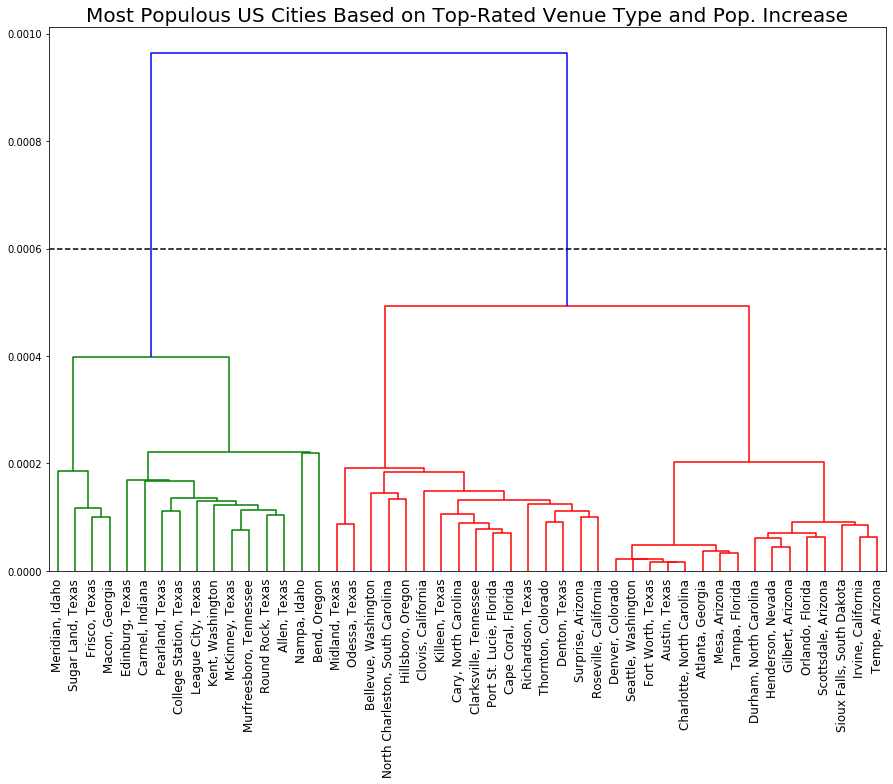

In [36]:
# Perform hierarchical clustering among most populous US cities with highest % increase included in features
import scipy.cluster.hierarchy as shc

def llf(id):
    return '%s' % (features_df.index[id])

plt.figure(figsize = (15, 10))
plt.title('Most Populous US Cities Based on Top-Rated Venue Type and Pop. Increase', fontsize=20)
dend = shc.dendrogram(shc.linkage(data_scaled_w_pop, method='ward'), leaf_label_func=llf, leaf_font_size=12)
plt.axhline(y=0.0006, color='k', linestyle='--')

Drawing colored boxes around the clusters:

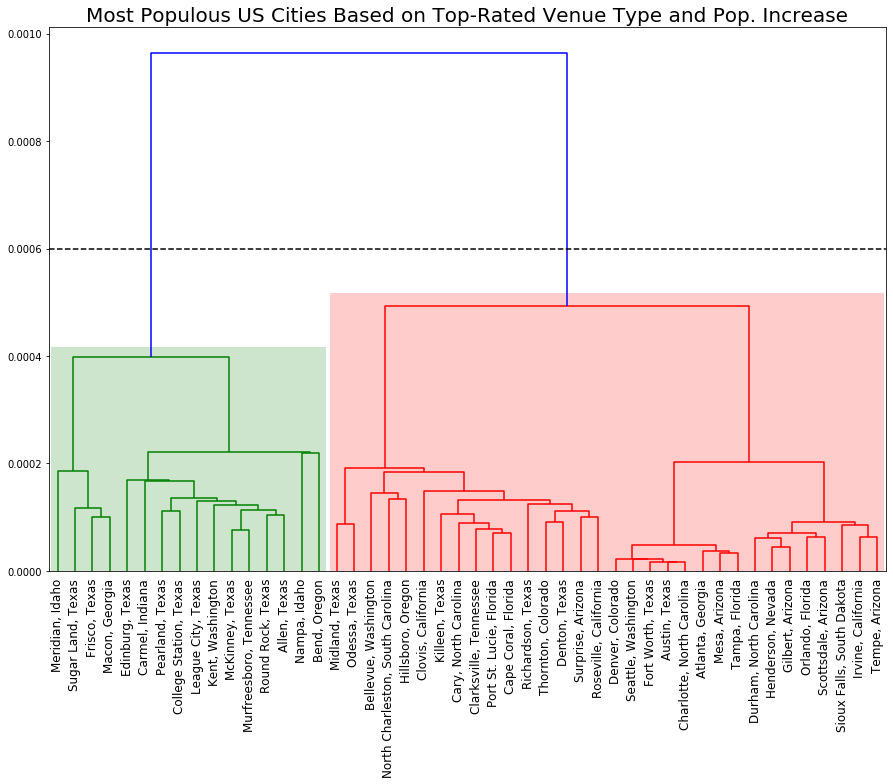

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (15, 10))
plt.title('Most Populous US Cities Based on Top-Rated Venue Type and Pop. Increase', fontsize=20)
dend = shc.dendrogram(shc.linkage(data_scaled_w_pop, method='ward'), leaf_label_func=llf, leaf_font_size=12)
plt.axhline(y=0.0006, color='k', linestyle='--')
for coll in ax.collections[:-1]:  # the last collection is the ungrouped level
    xmin, xmax = np.inf, -np.inf
    ymax = -np.inf
    for p in coll.get_paths():
        box = p.get_extents()
        (x0, _), (x1, y1) = p.get_extents().get_points()
        xmin = min(xmin, x0)
        xmax = max(xmax, x1)
        ymax = max(ymax, y1)
    rec = plt.Rectangle((xmin - 4, 0), xmax - xmin + 8, ymax*1.05,
                        facecolor=coll.get_color()[0], alpha=0.2, edgecolor="none")
    ax.add_patch(rec)

The right, red-colored cluster contains a sub-cluster just to the left of the lower-right corner of the dendrogram. This sub-cluster consists of five cities: Denver, CO; Seattle, WA; Charlotte, NC; Austin, TX; and Fort Worth, TX. Each of these cities appear to have the closest similarity since all of their links have a small and similar height in the dendrogram. For this reason, we explore these five cities further. First we check to see how the dendrogram changes when the population demographics are removed to ensure that we have fairly similar top rated venues around the respective city centers.

In [38]:
# investigate how the dendrogram changes without population demographics
data_scaled_no_pop = normalize(features_df.drop(columns=['2018 Estimate', '% Change (Pop)']))
data_scaled_no_pop = pd.DataFrame(data_scaled_no_pop, columns=features_df.drop(columns=['2018 Estimate', '% Change (Pop)']).columns)

In [39]:
data_scaled_no_pop.head()

,American Restaurant,Art Museum,BBQ Joint,Bar,Beer Bar,Bookstore,Bridge,Burger Joint,Café,Cajun / Creole Restaurant,...,Fair,Winery,Chiropractor,Government Building,Polish Restaurant,Boutique,Travel & Transport,Hawaiian Restaurant,Fondue Restaurant,Recreation Center
0,0.197814,0.065938,0.065938,0.197814,0.065938,0.065938,0.065938,0.131876,0.131876,0.065938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.305424,0.183254,0.061085,0.122169,0.122169,0.000000,0.000000,0.183254,0.061085,0.061085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.255031,0.063758,0.255031,0.063758,0.063758,0.063758,0.000000,0.127515,0.063758,0.063758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.061546,0.123091,0.000000,0.061546,0.061546,0.184637,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.422813,0.052852,0.052852,0.158555,0.000000,0.052852,0.000000,0.158555,0.158555,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


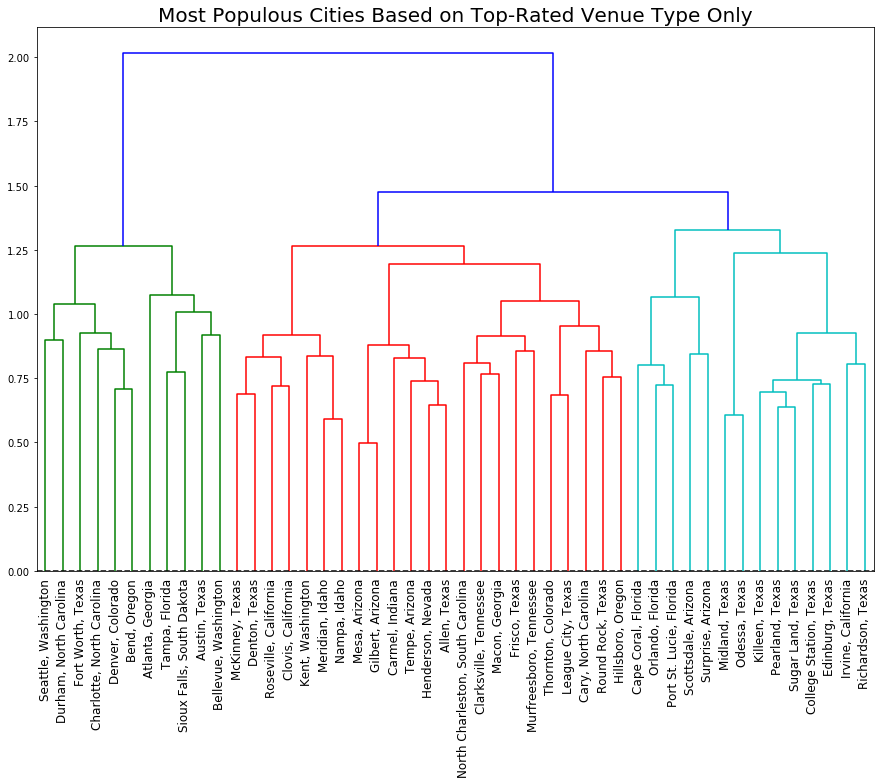

In [40]:
# Perform hierarchical clustering among most populous US cities without pop parameters (venue data as features only)

plt.figure(figsize = (15, 10))
plt.title('Most Populous Cities Based on Top-Rated Venue Type Only', fontsize=20)
dend = shc.dendrogram(shc.linkage(data_scaled_no_pop, method='ward'), leaf_label_func=llf, leaf_font_size=12)
plt.axhline(y=0.0006, color='k', linestyle='--')

Comparing the linkage height of the five cities: Seattle, WA; Denver, CO; Charlotte, NC; Austin, TX; and Fort Worth, TX; we see that these cities are fairly similar in top rated venue type. Therefore, we cluster the top rated venues for each city to see which venues appear to be most common amongst them. We cluster venues within each city using k-Means.

In [41]:
from sklearn.cluster import KMeans

### Denver, Colorado

In [42]:
cities_dfs['Denver, Colorado'].head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Denver Biscuit Co. @ Stanley,Comfort Food Restaurant,2501 Dallas St,39.752841,-104.877418,"[{'label': 'display', 'lat': 39.75284135445655...",826,80010,US,Aurora,CO,United States,"[2501 Dallas St, Aurora, CO 80010, United States]",NaN,NaN,589e6be4f16bb565085def3f
1,Stanley Marketplace,Shopping Plaza,2501 Dallas St,39.752868,-104.877429,"[{'label': 'display', 'lat': 39.75286764713476...",823,80010,US,Aurora,CO,United States,"[2501 Dallas St (E. 25th Ave.), Aurora, CO 800...",E. 25th Ave.,Northwest Aurora,54244df9498e4eeeb346f0a2
2,Comida @ Stanley,Mexican Restaurant,NaN,39.752996,-104.877904,"[{'label': 'display', 'lat': 39.75299614889717...",800,80010,US,Aurora,CO,United States,"[Aurora, CO 80010, United States]",NaN,NaN,585441dadebdf67a4d0e5b13
3,Station 26 Brewing Company,Brewery,7045 E 38th Ave,39.769459,-104.905971,"[{'label': 'display', 'lat': 39.76945923824451...",2459,80207,US,Denver,CO,United States,"[7045 E 38th Ave, Denver, CO 80207, United Sta...",NaN,NaN,527e84dc498e05d392436ac9
4,Chick-fil-A,Fast Food Restaurant,3601 Quebec St,39.767780,-104.903838,"[{'label': 'display', 'lat': 39.7677796, 'lng'...",2216,80207,US,Denver,CO,United States,"[3601 Quebec St, Denver, CO 80207, United States]",NaN,NaN,56cb604acd10b93123b7a960


In [43]:
cities_maps['Denver, Colorado']

In [44]:
cities_dfs['Denver, Colorado'][cities_dfs['Denver, Colorado']['postalCode'].isnull()]

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
61,Great Divide Barrel Bar,Brewery,1812 35th St,39.770444,-104.978987,"[{'label': 'display', 'lat': 39.77044406263746...",8549,NaN,US,Denver,CO,United States,"[1812 35th St (Brighton Blvd.), Denver, CO, Un...",Brighton Blvd.,NaN,557c84fb498e8dd042b88d97


### Seattle, Washington

In [45]:
cities_dfs['Seattle, Washington'].head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Seattle Center Playground,Playground,305 Harrison St,47.621869,-122.349254,"[{'label': 'display', 'lat': 47.62186859560178...",215,98109,US,Seattle,WA,United States,"[305 Harrison St, Seattle, WA 98109, United St...",NaN,NaN,555fca23498ebf779538a1e9
1,Chihuly Garden and Glass,Art Museum,305 Harrison St,47.620534,-122.350277,"[{'label': 'display', 'lat': 47.62053407471116...",62,98109,US,Seattle,WA,United States,"[305 Harrison St (at Seattle Center), Seattle,...",at Seattle Center,Lower Queen Anne,4f2334b8e4b0085e48b153c0
2,Seattle Center,Plaza,305 Harrison St,47.622190,-122.351475,"[{'label': 'display', 'lat': 47.62219030628736...",267,98109,US,Seattle,WA,United States,"[305 Harrison St (at 5th Ave), Seattle, WA 981...",at 5th Ave,NaN,42e18880f964a52066261fe3
3,Space Needle: Observation Deck,Scenic Lookout,400 Broad St,47.620515,-122.349330,"[{'label': 'display', 'lat': 47.6205147692609,...",76,98109,US,Seattle,WA,United States,"[400 Broad St, Seattle, WA 98109, United States]",NaN,NaN,4c3602ab93db0f475f511d92
4,MoPOP (Museum of Pop Culture (MoPOP)),Museum,325 5th Ave N,47.621526,-122.348054,"[{'label': 'display', 'lat': 47.621526, 'lng':...",224,98109,US,Seattle,WA,United States,"[325 5th Ave N (at Harrison St), Seattle, WA 9...",at Harrison St,NaN,43601880f964a5202d291fe3


In [46]:
cities_maps['Seattle, Washington']

### Charlotte, North Carolina

In [47]:
cities_dfs['Charlotte, North Carolina'].head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Duke Mansion,Bed & Breakfast,400 Hermitage Rd,35.201550,-80.827493,"[{'label': 'display', 'lat': 35.20154972108919...",285,28207,US,Charlotte,NC,United States,"[400 Hermitage Rd, Charlotte, NC 28207, United...",NaN,NaN,4b05863af964a520355922e3
1,Freedom Park,Park,1900 East Blvd,35.192609,-80.843485,"[{'label': 'display', 'lat': 35.19260875441761...",1477,28203,US,Charlotte,NC,United States,"[1900 East Blvd (btwn S Kings & Lombardy), Cha...",btwn S Kings & Lombardy,NaN,4b058642f964a520ab5a22e3
2,Trader Joe's,Grocery Store,1133 Metropolitan Ave,35.211608,-80.835468,"[{'label': 'display', 'lat': 35.21160846824355...",1384,28204,US,Charlotte,NC,United States,"[1133 Metropolitan Ave (Charlottetowne Ave), C...",Charlottetowne Ave,NaN,4b0b230bf964a5208c2d23e3
3,Duck Donuts,Donut Shop,1710 Kenilworth Avenue,35.202624,-80.844419,"[{'label': 'display', 'lat': 35.2026242, 'lng'...",1343,28203,US,Charlotte,NC,United States,"[1710 Kenilworth Avenue, Charlotte, NC 28203, ...",NaN,NaN,55f42d32498ecd91ca74af81
4,Viva Chicken Elizabeth Avenue,Peruvian Restaurant,1617 Elizabeth Ave,35.213407,-80.825966,"[{'label': 'display', 'lat': 35.21340676476259...",1536,28204,US,Charlotte,NC,United States,"[1617 Elizabeth Ave, Charlotte, NC 28204, Unit...",NaN,NaN,5101b86c3950fe1fc6f0e85f


### Austin, Texas

In [48]:
cities_dfs['Austin, Texas'].head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Hopfields,Gastropub,3110 Guadalupe St,30.298671,-97.740878,"[{'label': 'display', 'lat': 30.29867101720317...",889,78705,US,Austin,TX,United States,"[3110 Guadalupe St, Austin, TX 78705, United S...",NaN,NaN,4e1a2449aeb7eb0120dbf401
1,Via 313,Pizza Place,3016 Guadalupe St,30.297919,-97.741343,"[{'label': 'display', 'lat': 30.29791850205146...",863,78705,US,Austin,TX,United States,"[3016 Guadalupe St, Austin, TX 78705, United S...",NaN,NaN,56d4dfc8498e30f5748db0ed
2,FoodHeads,Sandwich Place,616 W 34th St,30.300751,-97.740348,"[{'label': 'display', 'lat': 30.30075071906708...",931,78705,US,Austin,TX,United States,[616 W 34th St (btwn Guadalupe St. & King St.)...,btwn Guadalupe St. & King St.,NaN,4a06e4cbf964a52009731fe3
3,Kerbey Lane Café,Café,3704 Kerbey Ln,30.308030,-97.750470,"[{'label': 'display', 'lat': 30.30803, 'lng': ...",895,78731,US,Austin,TX,United States,"[3704 Kerbey Ln, Austin, TX 78731, United States]",NaN,NaN,414f6f00f964a520f61c1fe3
4,Central Market,Gourmet Shop,4001 N Lamar Blvd,30.307610,-97.739876,"[{'label': 'display', 'lat': 30.3076098, 'lng'...",1290,78756,US,Austin,TX,United States,"[4001 N Lamar Blvd, Austin, TX 78756, United S...",NaN,NaN,436e9900f964a520e0291fe3


In [49]:
cities_maps['Austin, Texas']

### Fort Worth, Texas

In [50]:
cities_dfs['Fort Worth, Texas'].head()

,name,categories,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,address,neighborhood,crossStreet,id
0,Fort Worth Stockyards National Historic District,Neighborhood,32.788794,-97.346710,"[{'label': 'display', 'lat': 32.78879431520580...",1163,76164,US,Fort Worth,TX,United States,"[Fort Worth, TX 76164, United States]",NaN,NaN,NaN,4c2aaf16197e95210985628d
1,Coyote Drive-In,Drive-in Theater,32.764778,-97.335726,"[{'label': 'display', 'lat': 32.764778, 'lng':...",1741,76164,US,Fort Worth,TX,United States,"[223 Northeast 4th Street, Fort Worth, TX 7616...",223 Northeast 4th Street,Panther Island,NaN,517569b1498efc18c773c372
2,Joe T. Garcia's,Mexican Restaurant,32.784666,-97.348159,"[{'label': 'display', 'lat': 32.78466620186836...",923,76164,US,Fort Worth,TX,United States,"[2201 N Commerce St (at N.E. 22nd St.), Fort W...",2201 N Commerce St,NaN,at N.E. 22nd St.,4a762fcdf964a52084e21fe3
3,Trinity Trails,Trail,32.760717,-97.331057,"[{'label': 'display', 'lat': 32.76071688548088...",2304,76107,US,Fort Worth,TX,United States,"[Taylor St, Fort Worth, TX 76107, United States]",Taylor St,NaN,NaN,4e90648c30f81ec6ff74c135
4,El Asadero,Mexican Restaurant,32.780526,-97.348833,"[{'label': 'display', 'lat': 32.78052559465342...",828,76164,US,Fort Worth,TX,United States,"[1535 N Main St, Fort Worth, TX 76164, United ...",1535 N Main St,NaN,NaN,4ac0e64bf964a520e99420e3


In [51]:
cities_maps['Fort Worth, Texas']